# Setup

Ensure all dependencies are installed.


In [1]:
%pip install -U -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Check if we have GPU support, and if not, warn the user.


In [2]:
import torch
import warnings

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    warnings.warn("CUDA is not available. Running on CPU.")

CUDA is available!


Load our dataset...


In [1]:
import os
from data_sources.modelnet40 import ModelNet40
from models.dataset import PointCloudDataset
from models.data_source_info import DataSourceInfo
from typing import List
import json

train_folder = "data/train"
test_folder = "data/test"
info_folder = "data"

train_dataset: PointCloudDataset = None
test_dataset: PointCloudDataset = None
datasource_info: DataSourceInfo = None

if (
    os.path.exists(train_folder)
    and os.path.exists(test_folder)
    and os.path.exists(os.path.join(info_folder, "data_info.json"))
):
    print("Train and test data found. Reading data...")
    train_files: List[str] = []
    test_files: List[str] = []

    for root, dirs, files in os.walk(train_folder):
        for file in files:
            train_files.append(os.path.join(root, file))

    for root, dirs, files in os.walk(test_folder):
        for file in files:
            test_files.append(os.path.join(root, file))

    train_dataset = PointCloudDataset(train_files)
    test_dataset = PointCloudDataset(test_files)
    datasource_info = DataSourceInfo(
        **json.load(open(os.path.join(info_folder, "data_info.json"), "r"))
    )
else:
    datasource_info, train_dataset, test_dataset = ModelNet40.download(
        npoints=1000,
        train_outdir=train_folder,
        test_outdir=test_folder,
        info_outdir=info_folder,
    )

print(f"Training data: {len(train_dataset)} samples")
print(f"Test data size: {len(test_dataset)} samples")
print(f"Class count: {len(datasource_info.class_names)}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Train and test data found. Reading data...
Training data: 9843 samples
Test data size: 2468 samples
Class count: 40


# Training

Train a new classifier or load a new pre-trained one:


In [4]:
from pointnet.classification import train_classifier, evaluate_classifier
from pointnet.model import PointNetCls
import os
import torch
from utils.string import format_accuracy

classifier_path = "pointnet/cls/cls_model_24.pth"  # pointnet/cls/cls_model_24.pth

if classifier_path and os.path.exists(classifier_path):
    print(f"Loading existing model from {classifier_path}...")
    classifier = PointNetCls(k=len(datasource_info.class_names))
    classifier.load_state_dict(torch.load(classifier_path, weights_only=True))
    print("Classifier loaded successfully.")

    acc, acc_by_class = evaluate_classifier(classifier, test_dataset)

    print(f"Overall accuracy: {format_accuracy(acc)}")
    print("Accuracy by class:")
    for i, class_acc in acc_by_class.items():
        print(f"{datasource_info.class_names[i]}: {format_accuracy(class_acc)}")

else:
    classifier = train_classifier(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        k=len(datasource_info.class_names),
        epochs=25,
        outf="./pointnet/cls",
    )

Loading existing model from pointnet/cls/cls_model_24.pth...
Classifier loaded successfully.


Evaluating classifier:   0%|          | 0/2468 [00:00<?, ?it/s]

Overall accuracy: 87.76%
Accuracy by class:
airplane: 100.00%
bathtub: 94.00%
bed: 93.00%
bench: 80.00%
bookshelf: 85.00%
bottle: 96.00%
bowl: 85.00%
car: 97.00%
chair: 98.00%
cone: 90.00%
cup: 45.00%
curtain: 85.00%
desk: 84.88%
door: 65.00%
dresser: 80.23%
flower_pot: 30.00%
glass_box: 85.00%
guitar: 98.00%
keyboard: 95.00%
lamp: 80.00%
laptop: 100.00%
mantel: 95.00%
monitor: 96.00%
night_stand: 75.58%
person: 85.00%
piano: 87.00%
plant: 66.00%
radio: 65.00%
range_hood: 93.00%
sink: 80.00%
sofa: 97.00%
stairs: 75.00%
stool: 65.00%
table: 97.00%
tent: 90.00%
toilet: 97.00%
tv_stand: 84.00%
vase: 80.00%
wardrobe: 60.00%
xbox: 65.00%


Run classification on a random test entry to visualize it:


✓ Predicted class: table (33)


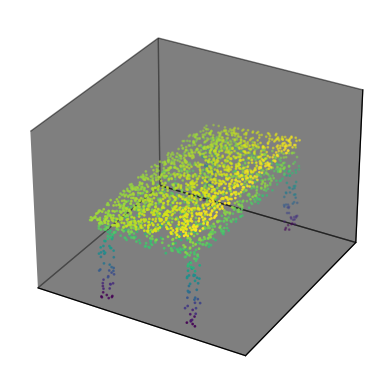

In [7]:
import random
import torch
from utils.plot import plot_points
from utils.display import show_collapsible_list

i = random.randint(0, len(test_dataset) - 1)

input_data = test_dataset[i][0].unsqueeze(0)
input_data = input_data.transpose(1, 2)

classifier.eval()

with torch.no_grad():
    output = classifier(input_data)


scores: torch.Tensor = output[0][0]
exp = int(test_dataset[i][1])
pre = scores.argmax().item()
show_collapsible_list("Scores", map(lambda x: str(x), scores.tolist()))
if exp == pre:
    print(
        f"\033[32m✓\033[0m Predicted class: \033[32m{datasource_info.class_names[pre]} ({pre})\033[0m"
    )
else:
    print(
        f"\033[31m✗\033[0m Predicted class: \033[31m{datasource_info.class_names[exp]} ({exp})\033[0m (Expected: {datasource_info.class_names[pre]} ({pre}))"
    )

points = input_data[0].transpose(0, 1).numpy()
plot_points(points)

Train the segmenter:


In [8]:
from pointnet.segmentation import train_segmentation

train_segmentation(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    k=len(datasource_info.class_names),
    epochs=25,
    class_choice=0,
    outf="./pointnet/seg",
)

Random Seed:  2407


ValueError: Expected input batch_size (80000) to match target batch_size (32).